In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
pi = np.pi

In [243]:
def VOR2D( x, y, xj, yj ):
    rj2 = (x - xj)**2 + (y - yj)**2
    u = (y - yj) / (2*pi*rj2)
    v = -(x - xj) / (2*pi*rj2)
    return u, v

def SORC2D( x, y, xj, yj ):
    rj2 = (x - xj)**2 + (y - yj)**2
    u = (x - xj) / (2*pi*rj2)
    v = (y - yj) / (2*pi*rj2)
    return u, v

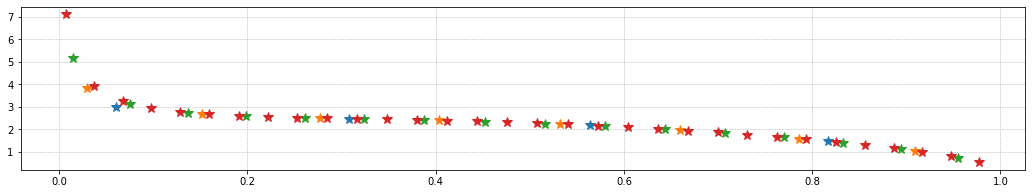

In [244]:
## parameters
C = 1
rho = 1
e = 0.1 * C
Q = 1 #freestream velocity
alpha = 10 #degrees
U = Q * np.cos( alpha * pi/180)
W = Q * np.sin( alpha * pi/180)


## original geometry
M = 1024 # number of points in geometry
X = np.linspace(0, C, M)
Y = 4 * e * X[:]/C * ( 1 - X[:]/C )
# Y = np.zeros(M)
tck, u = interpolate.splprep([X, Y], s=0)

## start figure
fig, ax = plt.subplots(figsize=(18, 3))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)

for k in range(2, 6):
    N = 2**k + 1
    dC = C/(N-1)
    ## discretization of geometry
    

    t0 = np.linspace(0, 1, N)
    t1 = np.linspace(0, 1, 4*N - 3 )
    u0 = np.asarray( interpolate.splev(t0, tck) )
    u1 = np.asarray( interpolate.splev(t1[1:-1:4], tck) )
    u2 = np.asarray( interpolate.splev(t1[3:-1:4], tck) )

    
    ## compute normals
    y1 = np.asarray( interpolate.splev(t1[3:-1:4], tck, der=1) )
    y2 = np.asarray( interpolate.splev(t1[3:-1:4], tck, der=2) )

    nx = np.asarray( - y1[1] / np.sqrt( y2[1, :]**2 + 1 ) )
    ny = np.asarray( 1 / np.sqrt( y2[1, :]**2 + 1 ) )
    
    
    ## create linear system of equations
    A = np.zeros( [N-1, N-1] )
    b = np.zeros( N-1 )
    for i in range(N-1):
        for j in range(N-1):
            u, w = VOR2D( u2[0, i], u2[1, i], u1[0, j], u1[1, j] )
            A[i, j] = u * nx[i] + w * ny[i]
    # create right-hand side
    for i in range(N-1):
        b[i] = -U * nx[i] - W * ny[i]
    
    # solve Ax = b
    gamma = np.linalg.solve(A , b)
    
    # plot results
    theoretical_solution = 4 * ( (C - u1[0])/u1[0] )**.5 * alpha *(pi/180) + 32*(e/C)* ( (u1[0]/C)*(1- u1[0]/C) )**.5
    ax.plot( u1[0], 2*gamma * rho * Q / dC, '*', markerSize=10)
#     ax.plot( u1[0], theoretical_solution, '-*', markerSize=10)

In [299]:
## parameters
C = 1
rho = 1
e = 0.1 * C
Q = 1 #freestream velocity
alpha = 0.0 #degrees
U = Q


## original geometry
M = 1024 # number of points in geometry
X = np.linspace(0, C, M)
Y = 4 * e * X[:]/C * ( 1 - X[:]/C )
# Y = np.zeros(M)
tck, u = interpolate.splprep([X, Y], s=0)


## discretization of geometry
N = 2**k + 1 #number of panels
N = 64
dC = C/(N-1)

# t0 = np.linspace(0, 1, N)
t1 = np.linspace(0, 1, 4*N - 3 )
# u0 = np.asarray( interpolate.splev(t0, tck) )
u1 = np.asarray( interpolate.splev(t1[2:-1:4], tck) )

## compute normals
y1 = np.asarray( interpolate.splev(t1[2:-1:4], tck, der=1) )
y2 = np.asarray( interpolate.splev(t1[2:-1:4], tck, der=2) )

nx = np.asarray( - y1[1] / np.sqrt( y2[1, :]**2 + 1 ) )
ny = np.asarray( 1 / np.sqrt( y2[1, :]**2 + 1 ) )
norm = (nx[:]**2 + ny[:]**2)**.5
tx = ny[:]/norm[:]
ty = -nx[:]/norm[:]

## create linear system of equations
A = np.zeros( [N-1, N-1] )
b = np.zeros( N-1 )
for i in range(N-1):
    for j in range(N-1):
        u, v = SORC2D( u1[0, i], u1[1, i], u1[0, j], 0.0 )
        A[i, j] = u * nx[i] + v * ny[i]
        
# create right-hand side
for i in range(N-1):
    b[i] = -U * nx[i]

# solve Ax = b
rho = np.linalg.solve(A , b)
summ = 0.0
for gam in rho:
    summ = summ + gam
print(summ)

-2.0816681711721685e-16


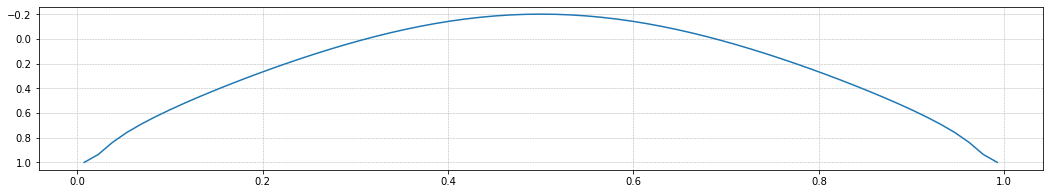

In [300]:
## start figure
fig, ax = plt.subplots(figsize=(18, 3))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
# ax.plot( u0[0], u0[1], '*' )
# ax.plot( u0[0], u0[1] * 0.0, '*' )

cp = np.zeros(N-1)
for i in range(N-1):
    Qx = 0.0
    Qy = 0.0
    for j in range(N-1):
        u, v = SORC2D( u1[0, i], u1[1, i], u1[0, j], 0.0 )
        u = rho[j] * u
        v = rho[j] * v
        Qx = Qx + u
        Qy = Qy + v
    Qx = Qx + Q
    Qx = Qx * tx[i]
    Qy = Qy * ty[i]
#     print(Qx, Qy)
    Qt2 = ( Qx**2 + Qy**2 )
    cp[i] = 1 - Qt2
    
ax.plot(u1[0], cp+(1-cp[0]))
plt.gca().invert_yaxis()
